<a href="https://colab.research.google.com/github/ElianGonzalez0202/Random-Forest/blob/main/Copia_de_Random_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# En profundidad: Árboles de decisión y bosques aleatorios

Anteriormente, analizamos en profundidad un clasificador generativo simple (Bayes ingenuo; véase [En profundidad: Clasificación Bayes ingenua](05.05-Naive-Bayes.ipynb)) y un potente clasificador discriminativo (máquinas de vectores de soporte; véase [En profundidad: Máquinas de vectores de soporte](05.07-Support-Vector-Machines.ipynb)).
Aquí analizaremos otro potente algoritmo: un algoritmo no paramétrico llamado *bosques aleatorios*.
Los bosques aleatorios son un ejemplo de un método de *conjunto*, es decir, uno que se basa en la agregación de los resultados de un conjunto de estimadores más simples.
El resultado, algo sorprendente, con estos métodos de conjunto es que la suma puede ser mayor que las partes: es decir, la precisión predictiva de una votación mayoritaria entre varios estimadores puede ser mejor que la de cualquiera de los estimadores individuales que realizan la votación.
Veremos ejemplos de esto en las siguientes secciones.

Comenzamos con las importaciones estándar:

In [60]:
!pip install seaborn
import seaborn as sns

In [61]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")

## Motivación de bosques aleatorios: árboles de decisión

Los bosques aleatorios son un ejemplo de un aprendizaje conjunto basado en árboles de decisión.
Por esta razón, comenzaremos analizando los árboles de decisión en sí.

Los árboles de decisión son formas extremadamente intuitivas de clasificar o etiquetar objetos: simplemente se formula una serie de preguntas diseñadas para determinar la clasificación.
Por ejemplo, si quisiera construir un árbol de decisión para clasificar los animales que encuentra durante una excursión, podría construir el que se muestra en la siguiente figura.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Example)

La división binaria hace que esto sea extremadamente eficiente: en un árbol bien construido, cada pregunta reducirá el número de opciones aproximadamente a la mitad, reduciendo rápidamente las opciones incluso entre un gran número de clases.
La clave, por supuesto, reside en decidir qué preguntas formular en cada paso.
En las implementaciones de aprendizaje automático de árboles de decisión, las preguntas generalmente adoptan la forma de divisiones alineadas con los ejes de los datos: es decir, cada nodo del árbol divide los datos en dos grupos utilizando un valor de corte dentro de una de las características.
Veamos ahora un ejemplo de esto.

### Creación de un árbol de decisiones
Considere los siguientes datos bidimensionales, que tienen una de cuatro etiquetas de clase (consulte la siguiente figura):

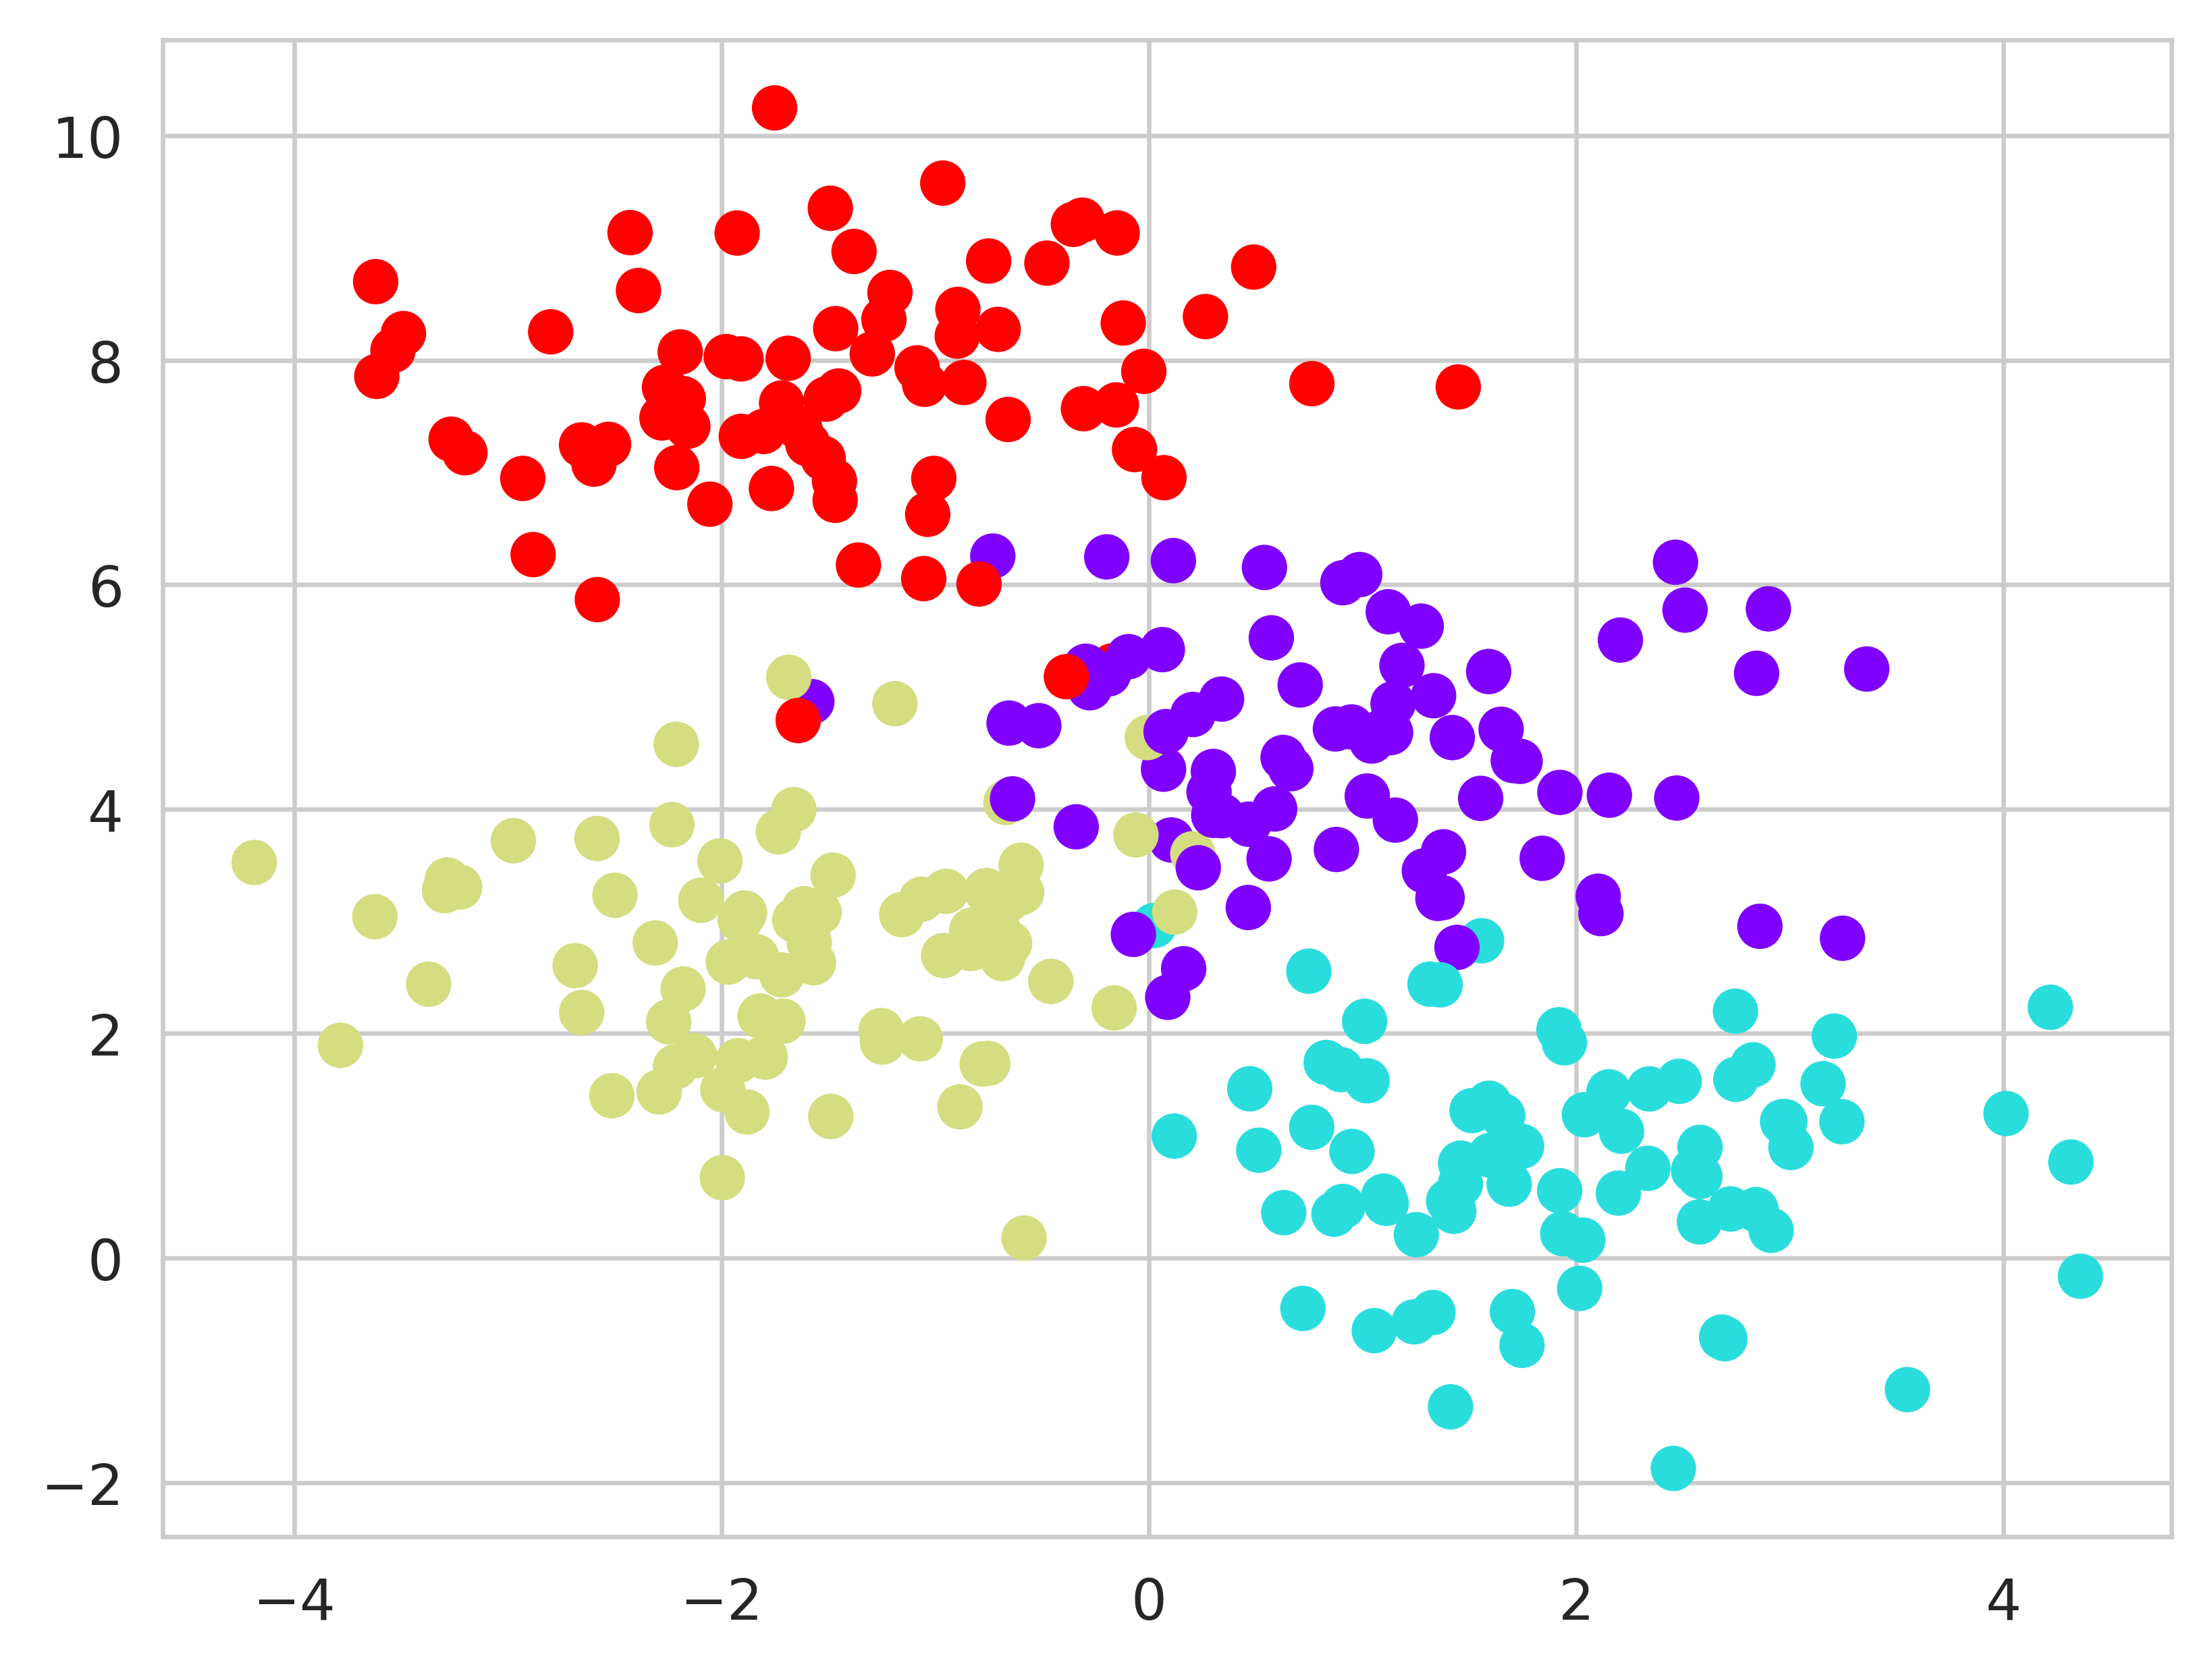

In [62]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Un árbol de decisión simple, construido a partir de estos datos, dividirá iterativamente los datos a lo largo de uno u otro eje según un criterio cuantitativo, y en cada nivel asignará la etiqueta de la nueva región según el voto mayoritario de sus puntos.
La siguiente figura presenta una visualización de los primeros cuatro niveles de un clasificador de árbol de decisión para estos datos.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree-levels.png?raw=1)
[Fuente de la figura en el Apéndice](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Levels)

Observe que, tras la primera división, todos los puntos de la rama superior permanecen inalterados, por lo que no es necesario subdividirla.
Excepto en el caso de los nodos que contienen todos un color, en cada nivel, *todas* las regiones se dividen de nuevo a lo largo de una de las dos entidades.

Este proceso de ajuste de un árbol de decisión a nuestros datos se puede realizar en Scikit-Learn con el estimador ``DecisionTreeClassifier``:

In [63]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Escribamos una función de utilidad para ayudarnos a visualizar la salida del clasificador:

In [64]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Ahora podemos examinar cómo se ve la clasificación del árbol de decisión (ver la siguiente figura):

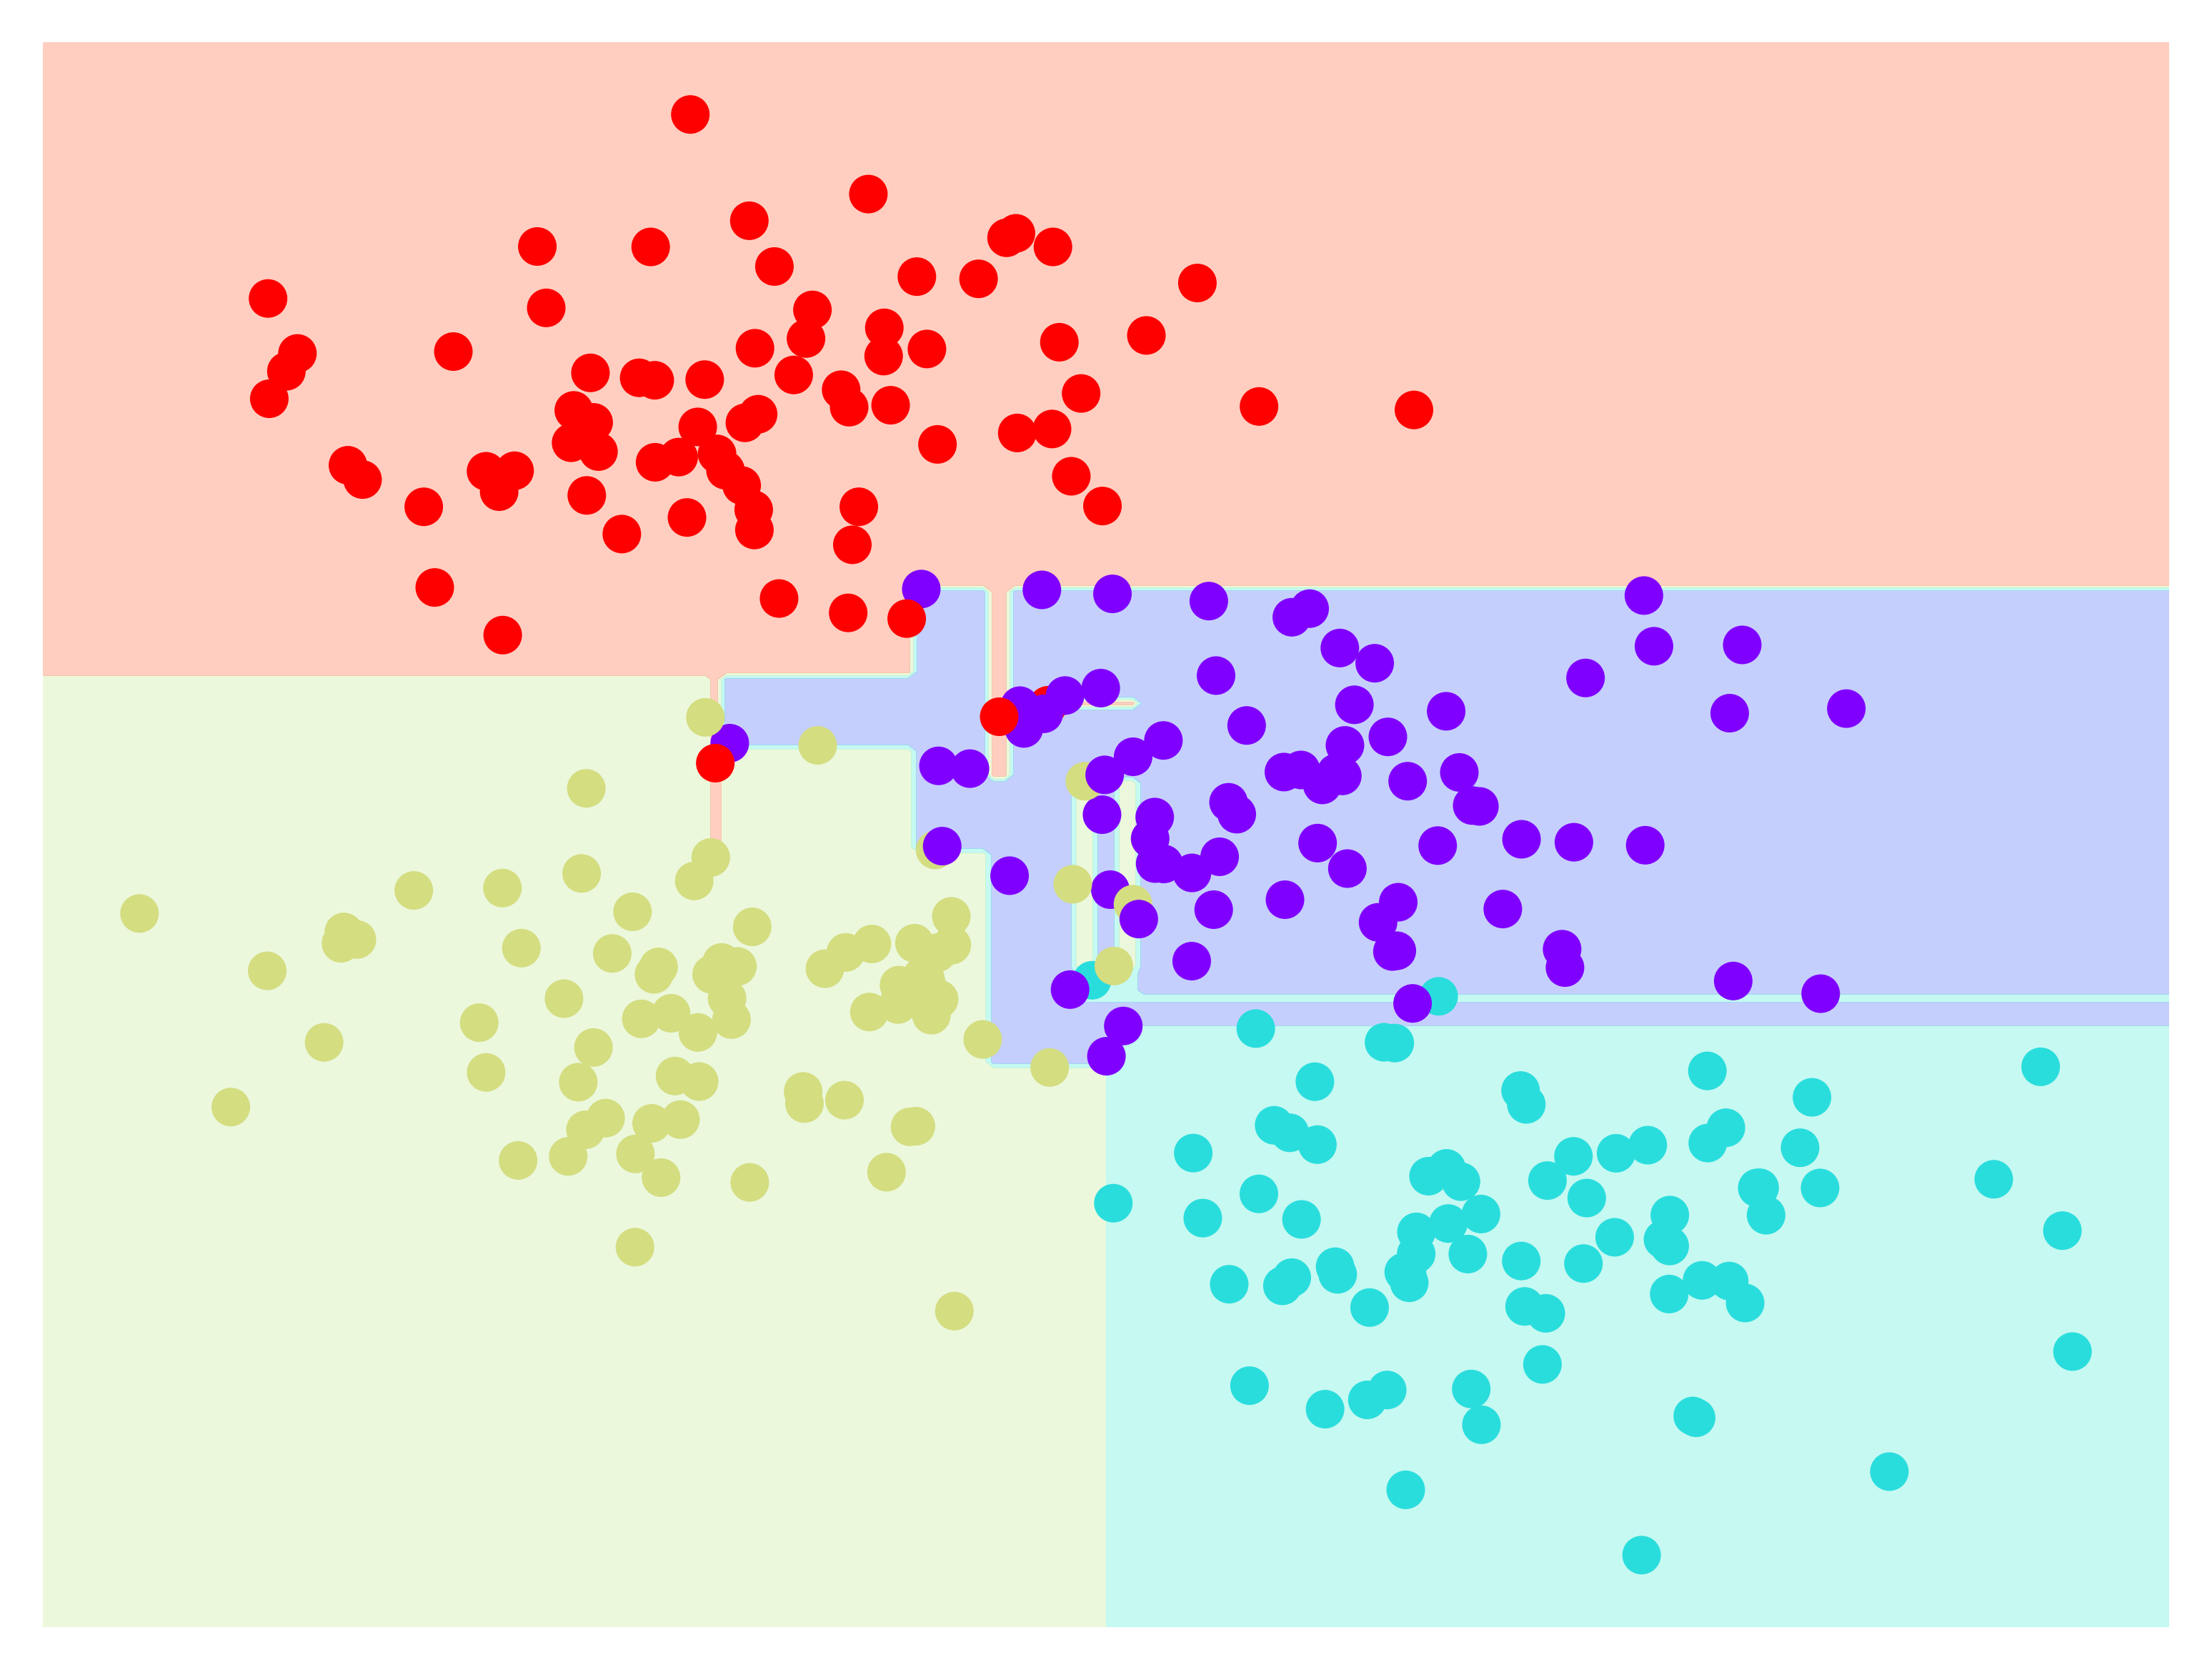

In [65]:
visualize_classifier(DecisionTreeClassifier(), X, y)

In [66]:

import helpers
helpers.plot_tree_interactive(X, y);

interactive(children=(IntSlider(value=5, description='depth', max=5, min=1), Output()), _dom_classes=('widget-…

Observe que, a medida que aumenta la profundidad, tendemos a obtener regiones de clasificación con formas muy extrañas; por ejemplo, a una profundidad de cinco, hay una región morada alta y estrecha entre las regiones amarilla y azul.
Es evidente que esto se debe menos a la distribución intrínseca de los datos, y más a las propiedades particulares de muestreo o ruido de los datos.
Es decir, este árbol de decisión, incluso con solo cinco niveles de profundidad, claramente sobreajusta nuestros datos.

### Árboles de decisión y sobreajuste

Este sobreajuste resulta ser una propiedad general de los árboles de decisión: es muy fácil profundizar demasiado en el árbol y, por lo tanto, ajustar los detalles de los datos específicos en lugar de las propiedades generales de las distribuciones de las que se extraen.
Otra forma de visualizar este sobreajuste es observar modelos entrenados con diferentes subconjuntos de datos; por ejemplo, en esta figura, entrenamos dos árboles diferentes, cada uno con la mitad de los datos originales.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree-overfitting.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Overfitting)

Es evidente que en algunos puntos los dos árboles producen resultados consistentes (por ejemplo, en las cuatro esquinas), mientras que en otros dan clasificaciones muy diferentes (por ejemplo, en las regiones entre dos grupos cualesquiera).
La ​​observación clave es que las inconsistencias tienden a ocurrir donde la clasificación es menos precisa y, por lo tanto, al utilizar la información de *ambos* árboles, podríamos obtener un mejor resultado.

Si está ejecutando este cuaderno en vivo, la siguiente función le permitirá mostrar de forma interactiva los ajustes de los árboles entrenados en un subconjunto aleatorio de los datos:

In [67]:
# helpers_05_08 is found in the online appendix
import helpers
helpers.randomized_tree_interactive(X, y)

interactive(children=(IntSlider(value=0, description='random_state'), Output()), _dom_classes=('widget-interac…

Así como el uso de información de dos árboles mejora nuestros resultados, podríamos esperar que el uso de información de muchos árboles mejoraría aún más nuestros resultados.

## Conjuntos de estimadores: bosques aleatorios
Esta noción —que se pueden combinar múltiples estimadores de sobreajuste para reducir el efecto de este— es la base de un método de conjunto llamado *bagging*.
El bagging utiliza un conjunto (quizás una especie de bolsa de sorpresas) de estimadores paralelos, cada uno de los cuales sobreajusta los datos y promedia los resultados para encontrar una mejor clasificación.
Un conjunto de árboles de decisión aleatorios se conoce como *random forest*.

Este tipo de clasificación bagging puede realizarse manualmente utilizando el metaestimador `BaggingClassifier` de Scikit-Learn, como se muestra aquí (véase la siguiente figura):

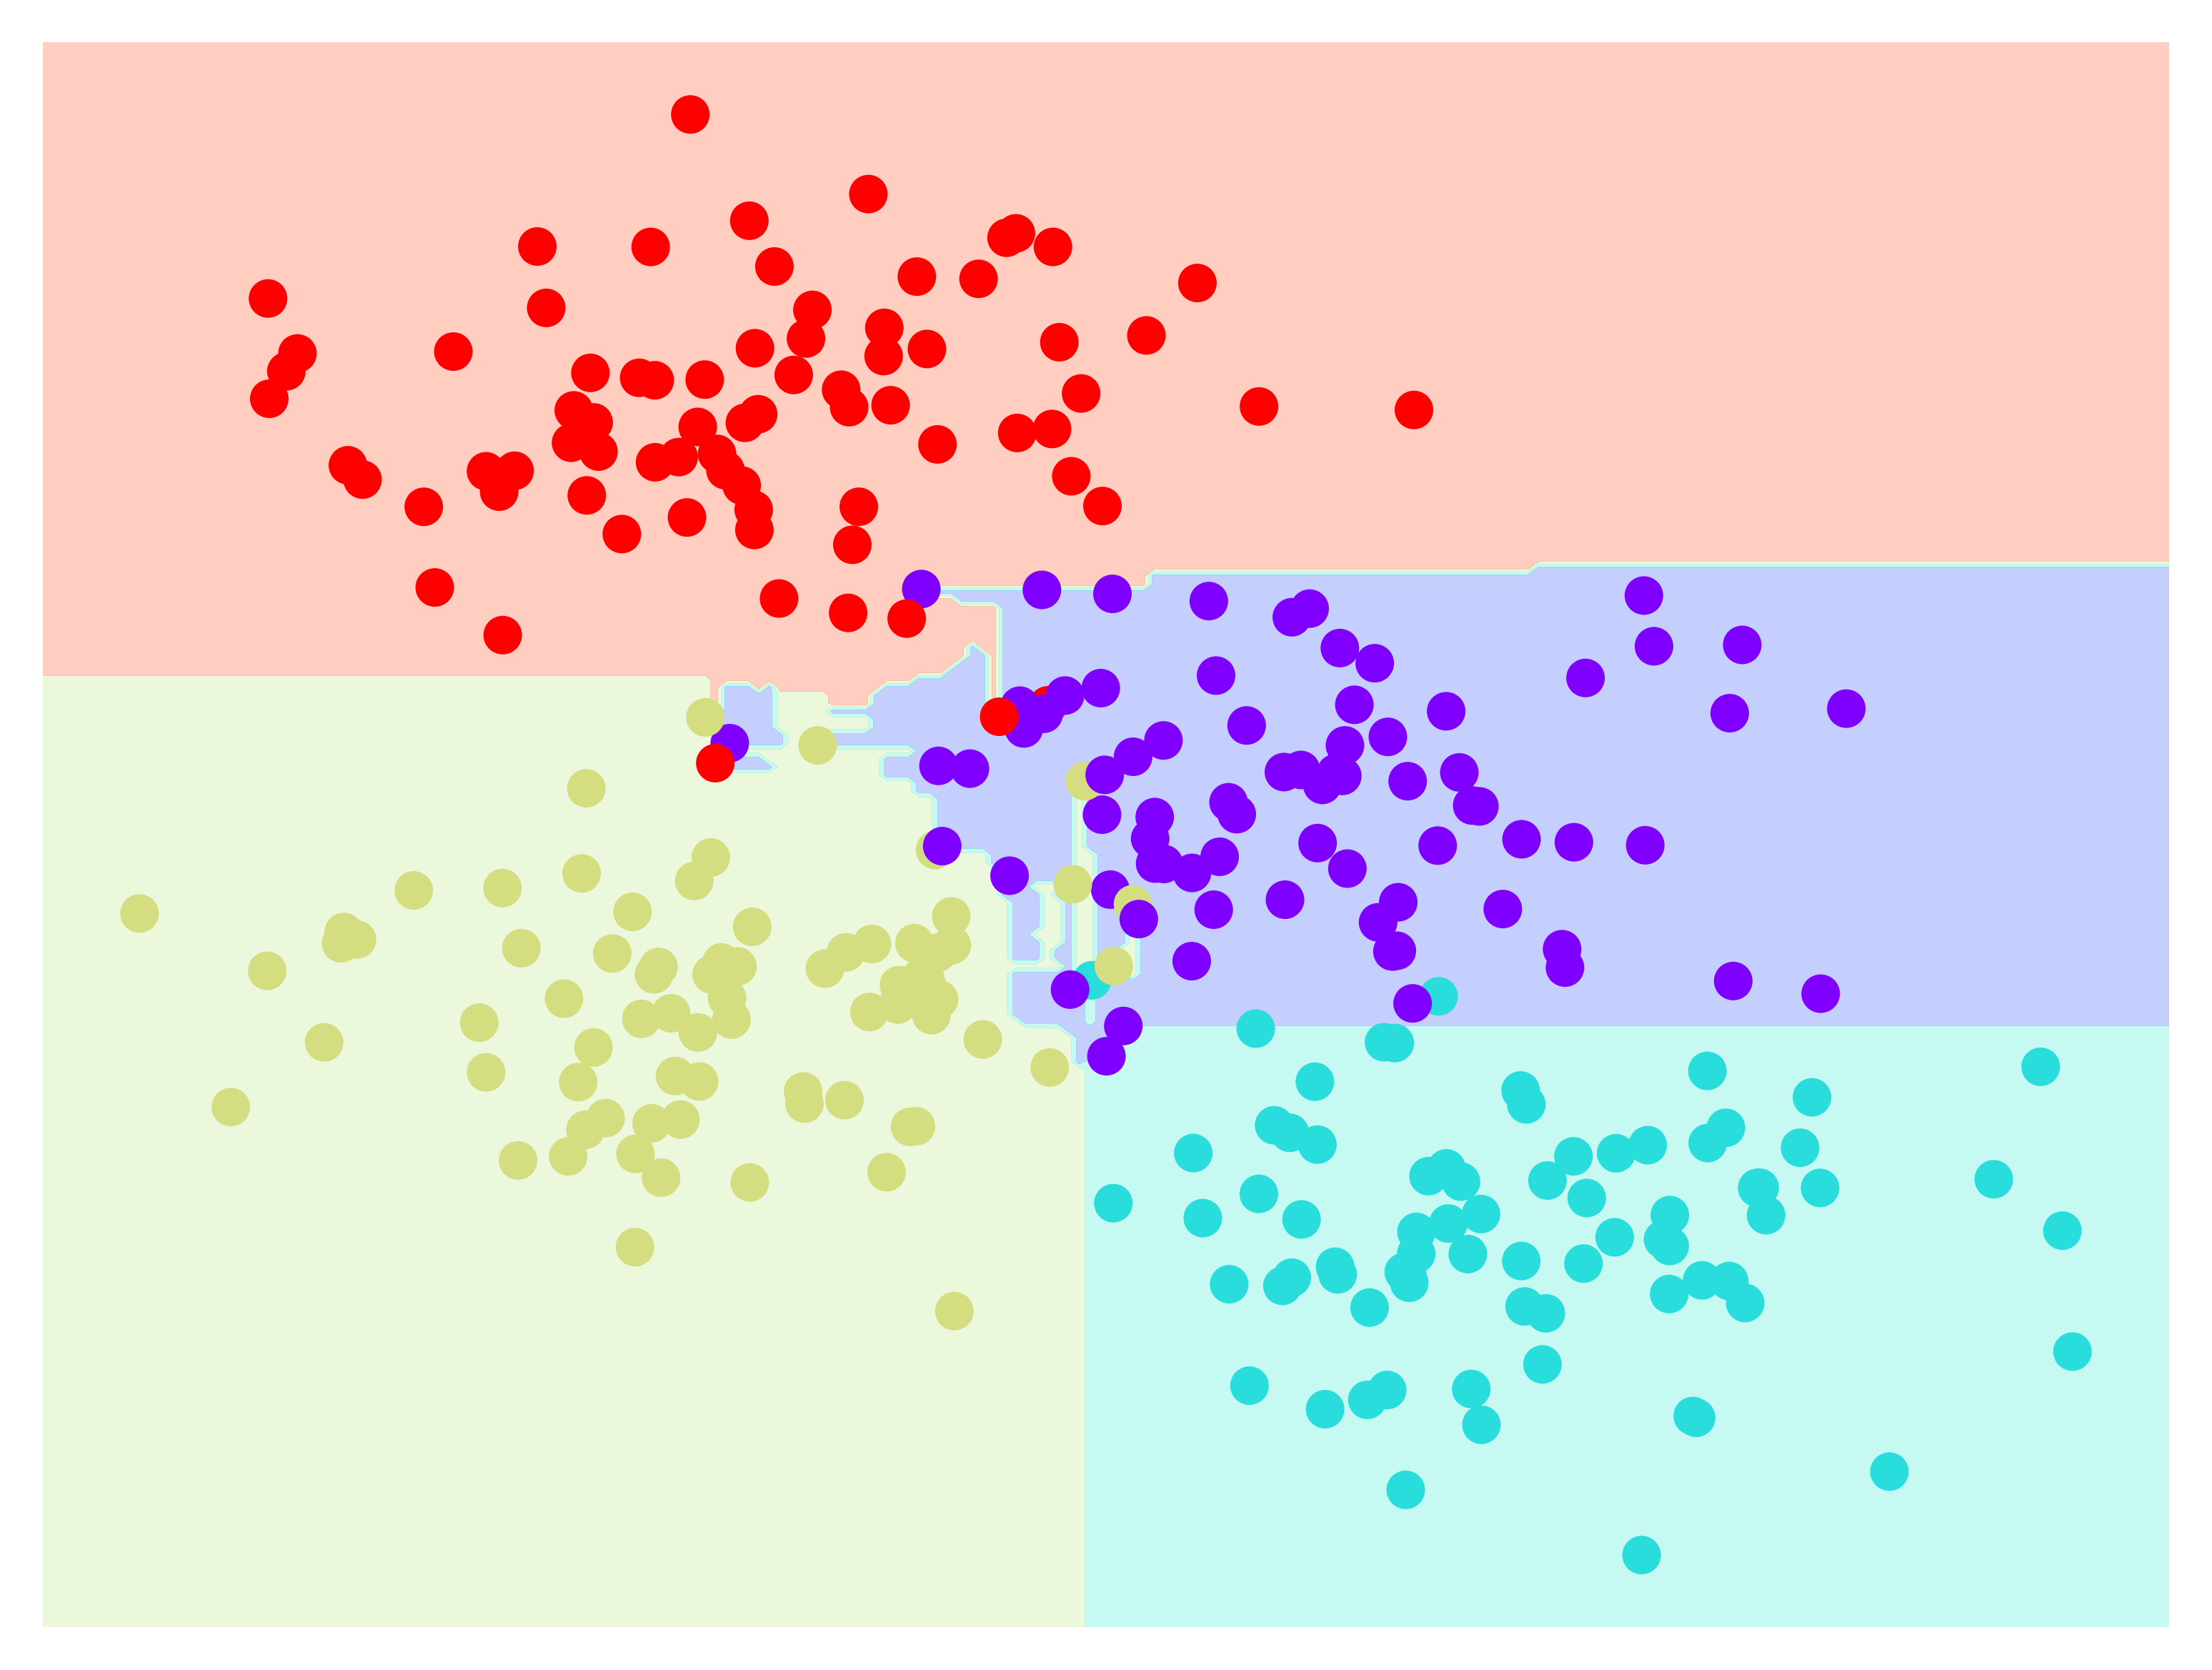

In [68]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

En este ejemplo, hemos aleatorizado los datos ajustando cada estimador con un subconjunto aleatorio del 80 % de los puntos de entrenamiento.
En la práctica, los árboles de decisión se aleatorizan de forma más eficaz al introducir cierta estocasticidad en la elección de las divisiones: de esta forma, todos los datos contribuyen al ajuste en cada ocasión, pero los resultados del ajuste conservan la aleatoriedad deseada.
Por ejemplo, al determinar la característica por la que se dividirá, el árbol aleatorizado podría seleccionar entre las principales características.
Puede consultar más detalles técnicos sobre estas estrategias de aleatorización en la [documentación de Scikit-Learn](http://scikit-learn.org/stable/modules/ensemble.html#forest) y sus referencias.

En Scikit-Learn, este conjunto optimizado de árboles de decisión aleatorizados se implementa en el estimador `RandomForestClassifier`, que se encarga de toda la aleatorización automáticamente. Todo lo que hay que hacer es seleccionar una cantidad de estimadores y muy rápidamente (en paralelo, si se desea) se ajustará el conjunto de árboles (ver la siguiente figura):

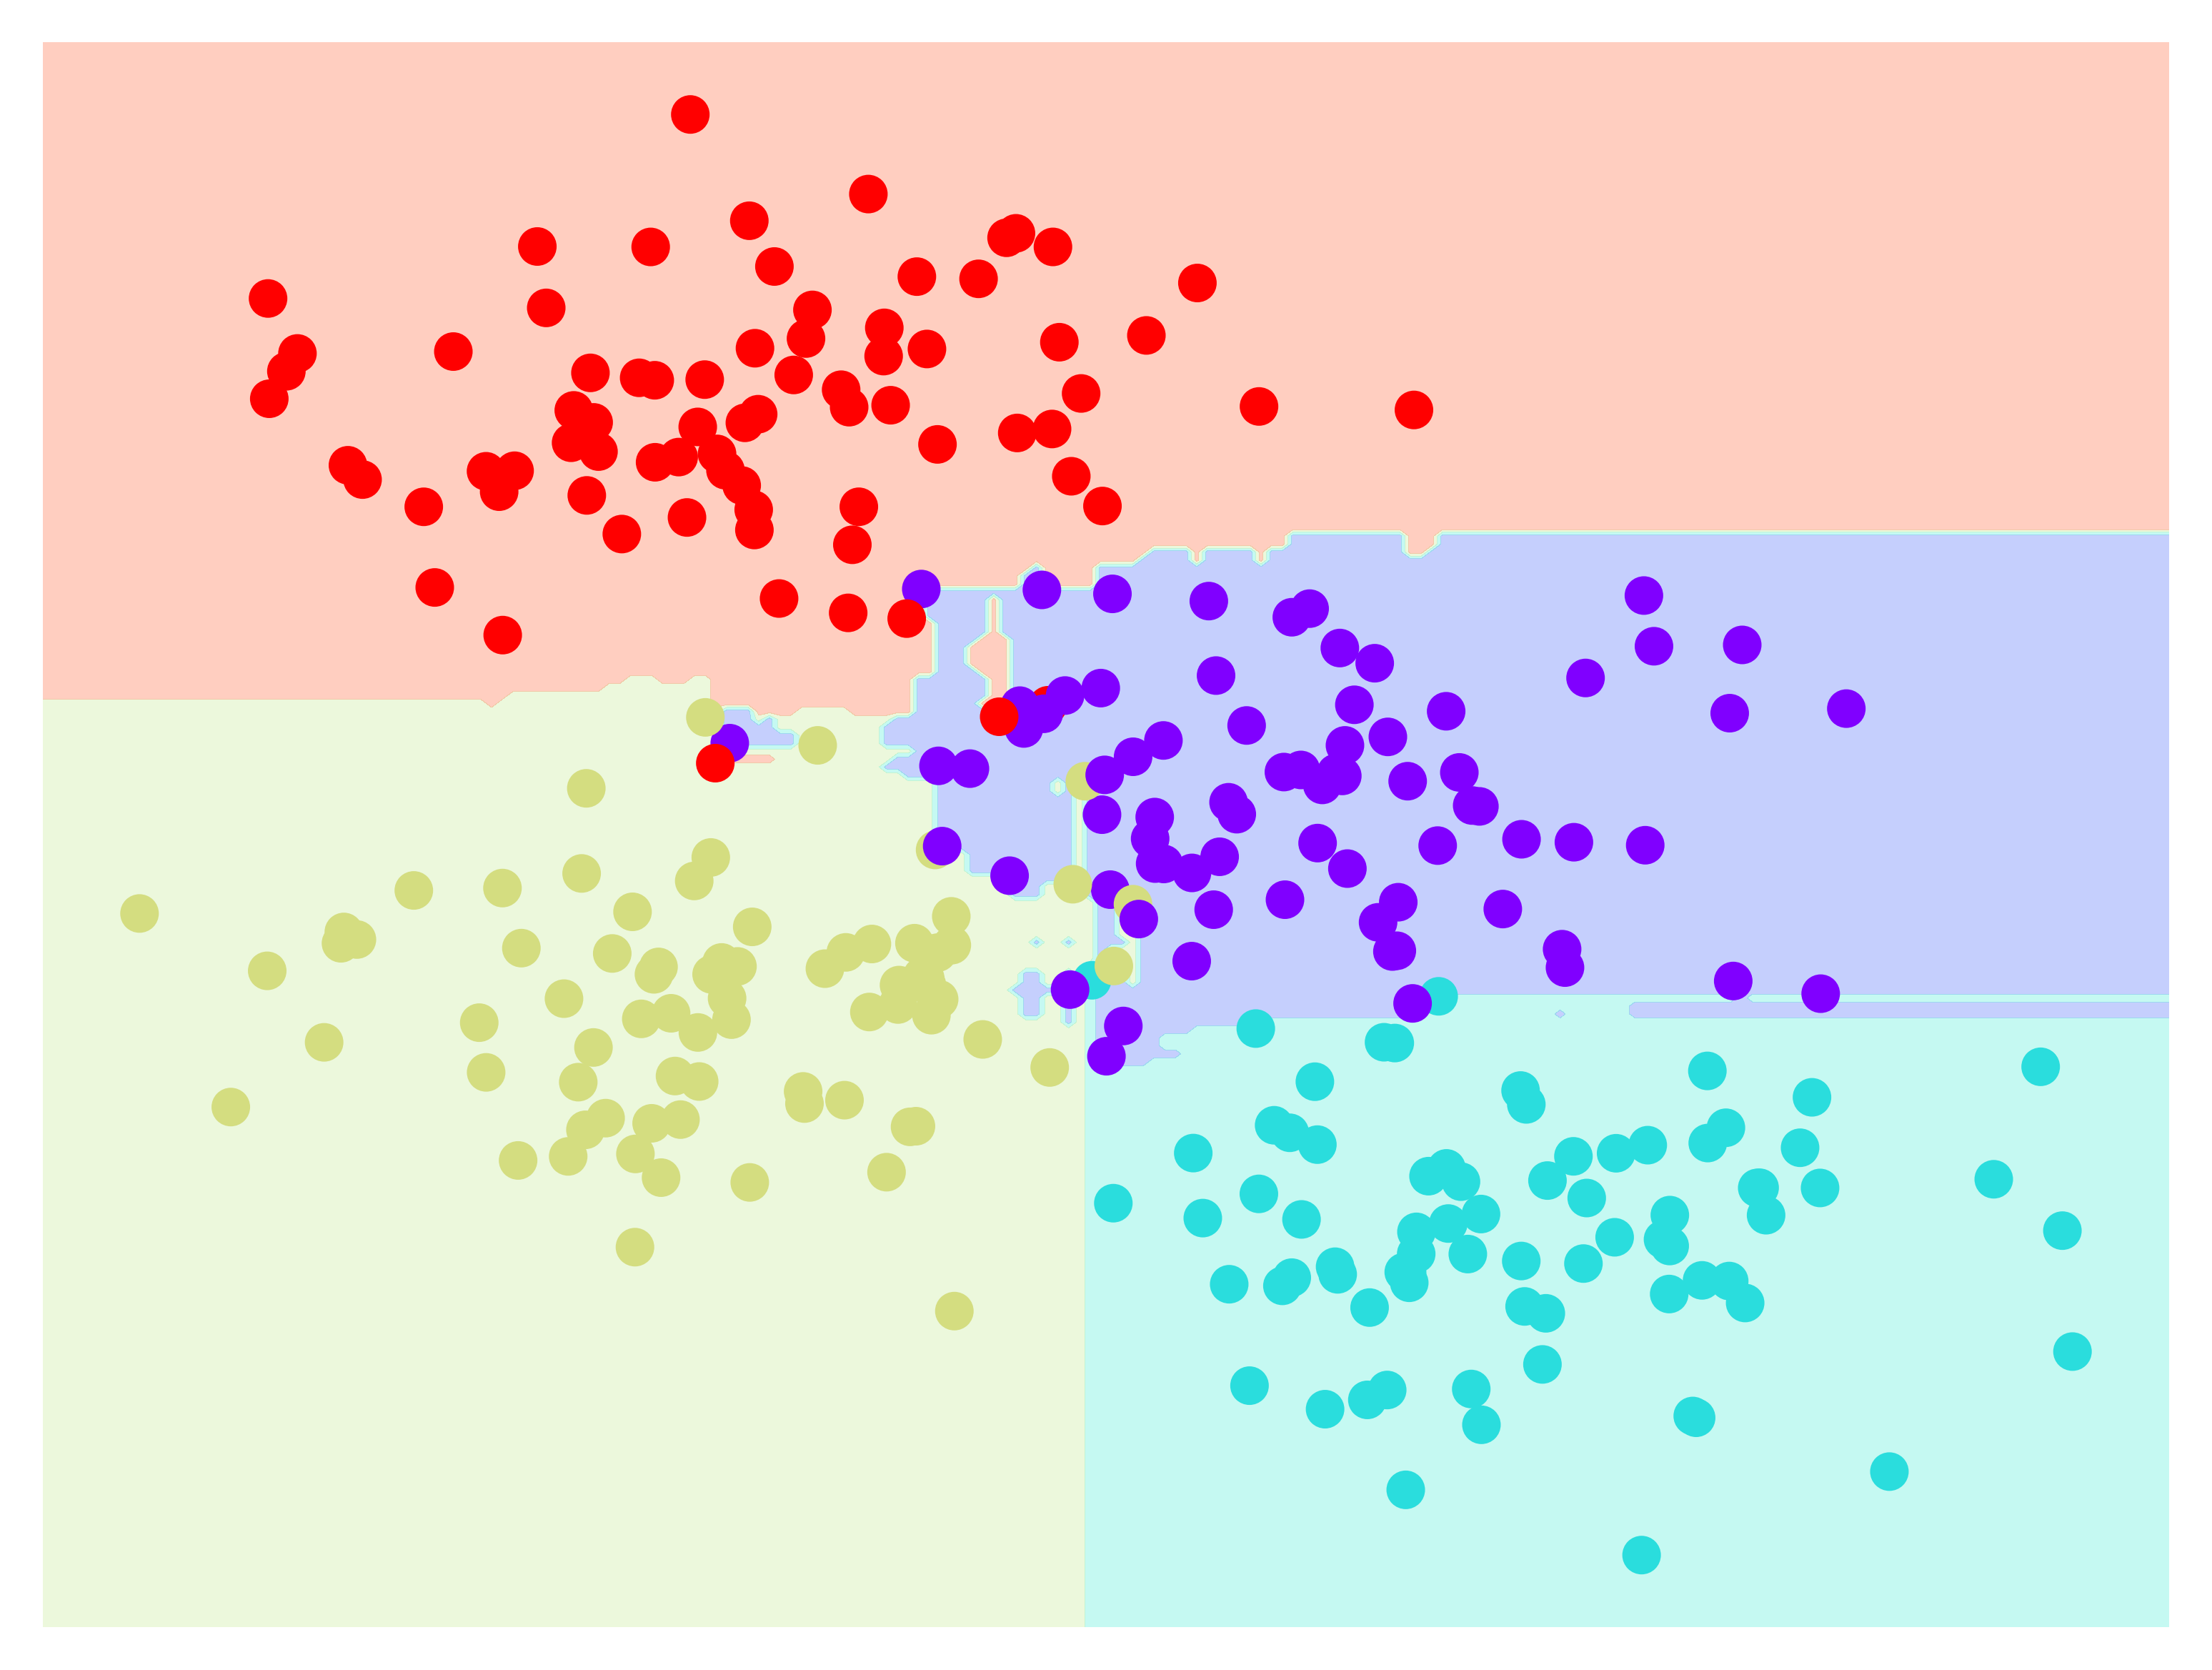

In [69]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

Vemos que al promediar más de 100 modelos perturbados aleatoriamente, terminamos con un modelo general que está mucho más cerca de nuestra intuición sobre cómo se debe dividir el espacio de parámetros.

## Regresión de bosque aleatorio
En la sección anterior, consideramos los bosques aleatorios en el contexto de la clasificación.
Los bosques aleatorios también pueden funcionar en el caso de la regresión (es decir, con variables continuas en lugar de categóricas). El estimador que se utiliza para esto es `RandomForestRegressor`, y la sintaxis es muy similar a la que vimos anteriormente.

Considere los siguientes datos, obtenidos de la combinación de una oscilación rápida y una lenta (véase la siguiente figura):

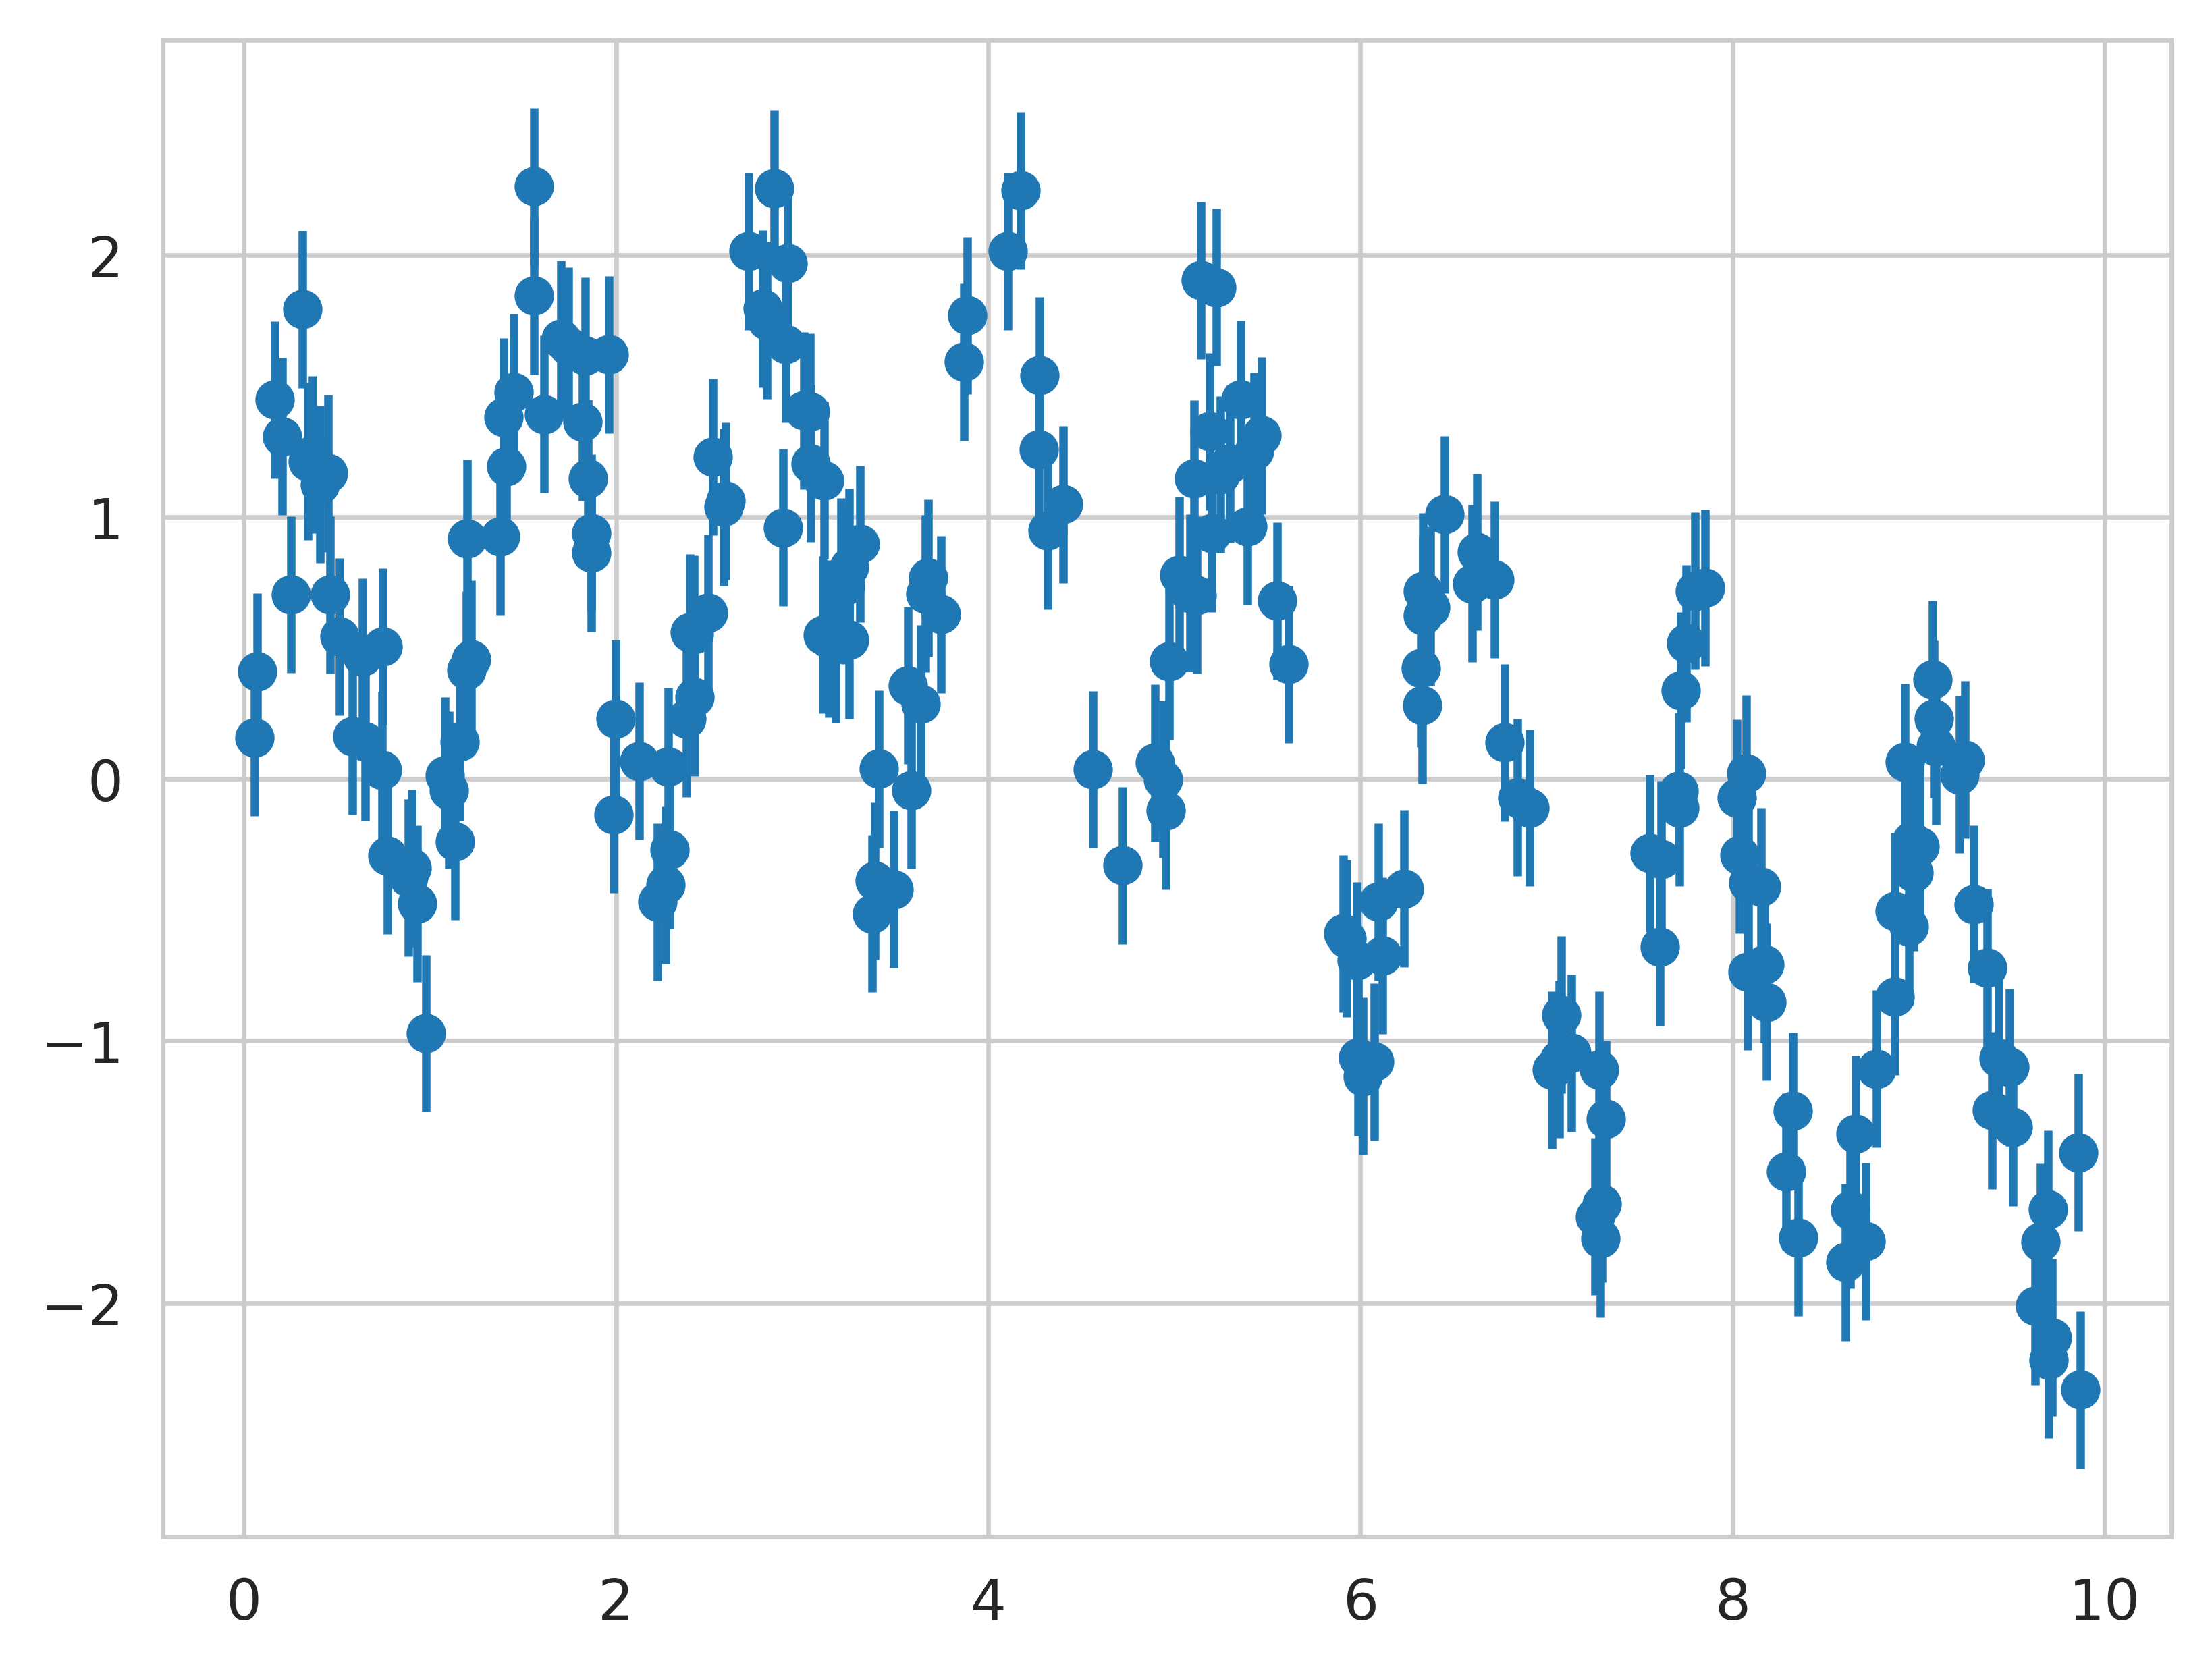

In [70]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

Utilizando el regresor de bosque aleatorio, podemos encontrar la curva de mejor ajuste de la siguiente manera (ver la siguiente figura):

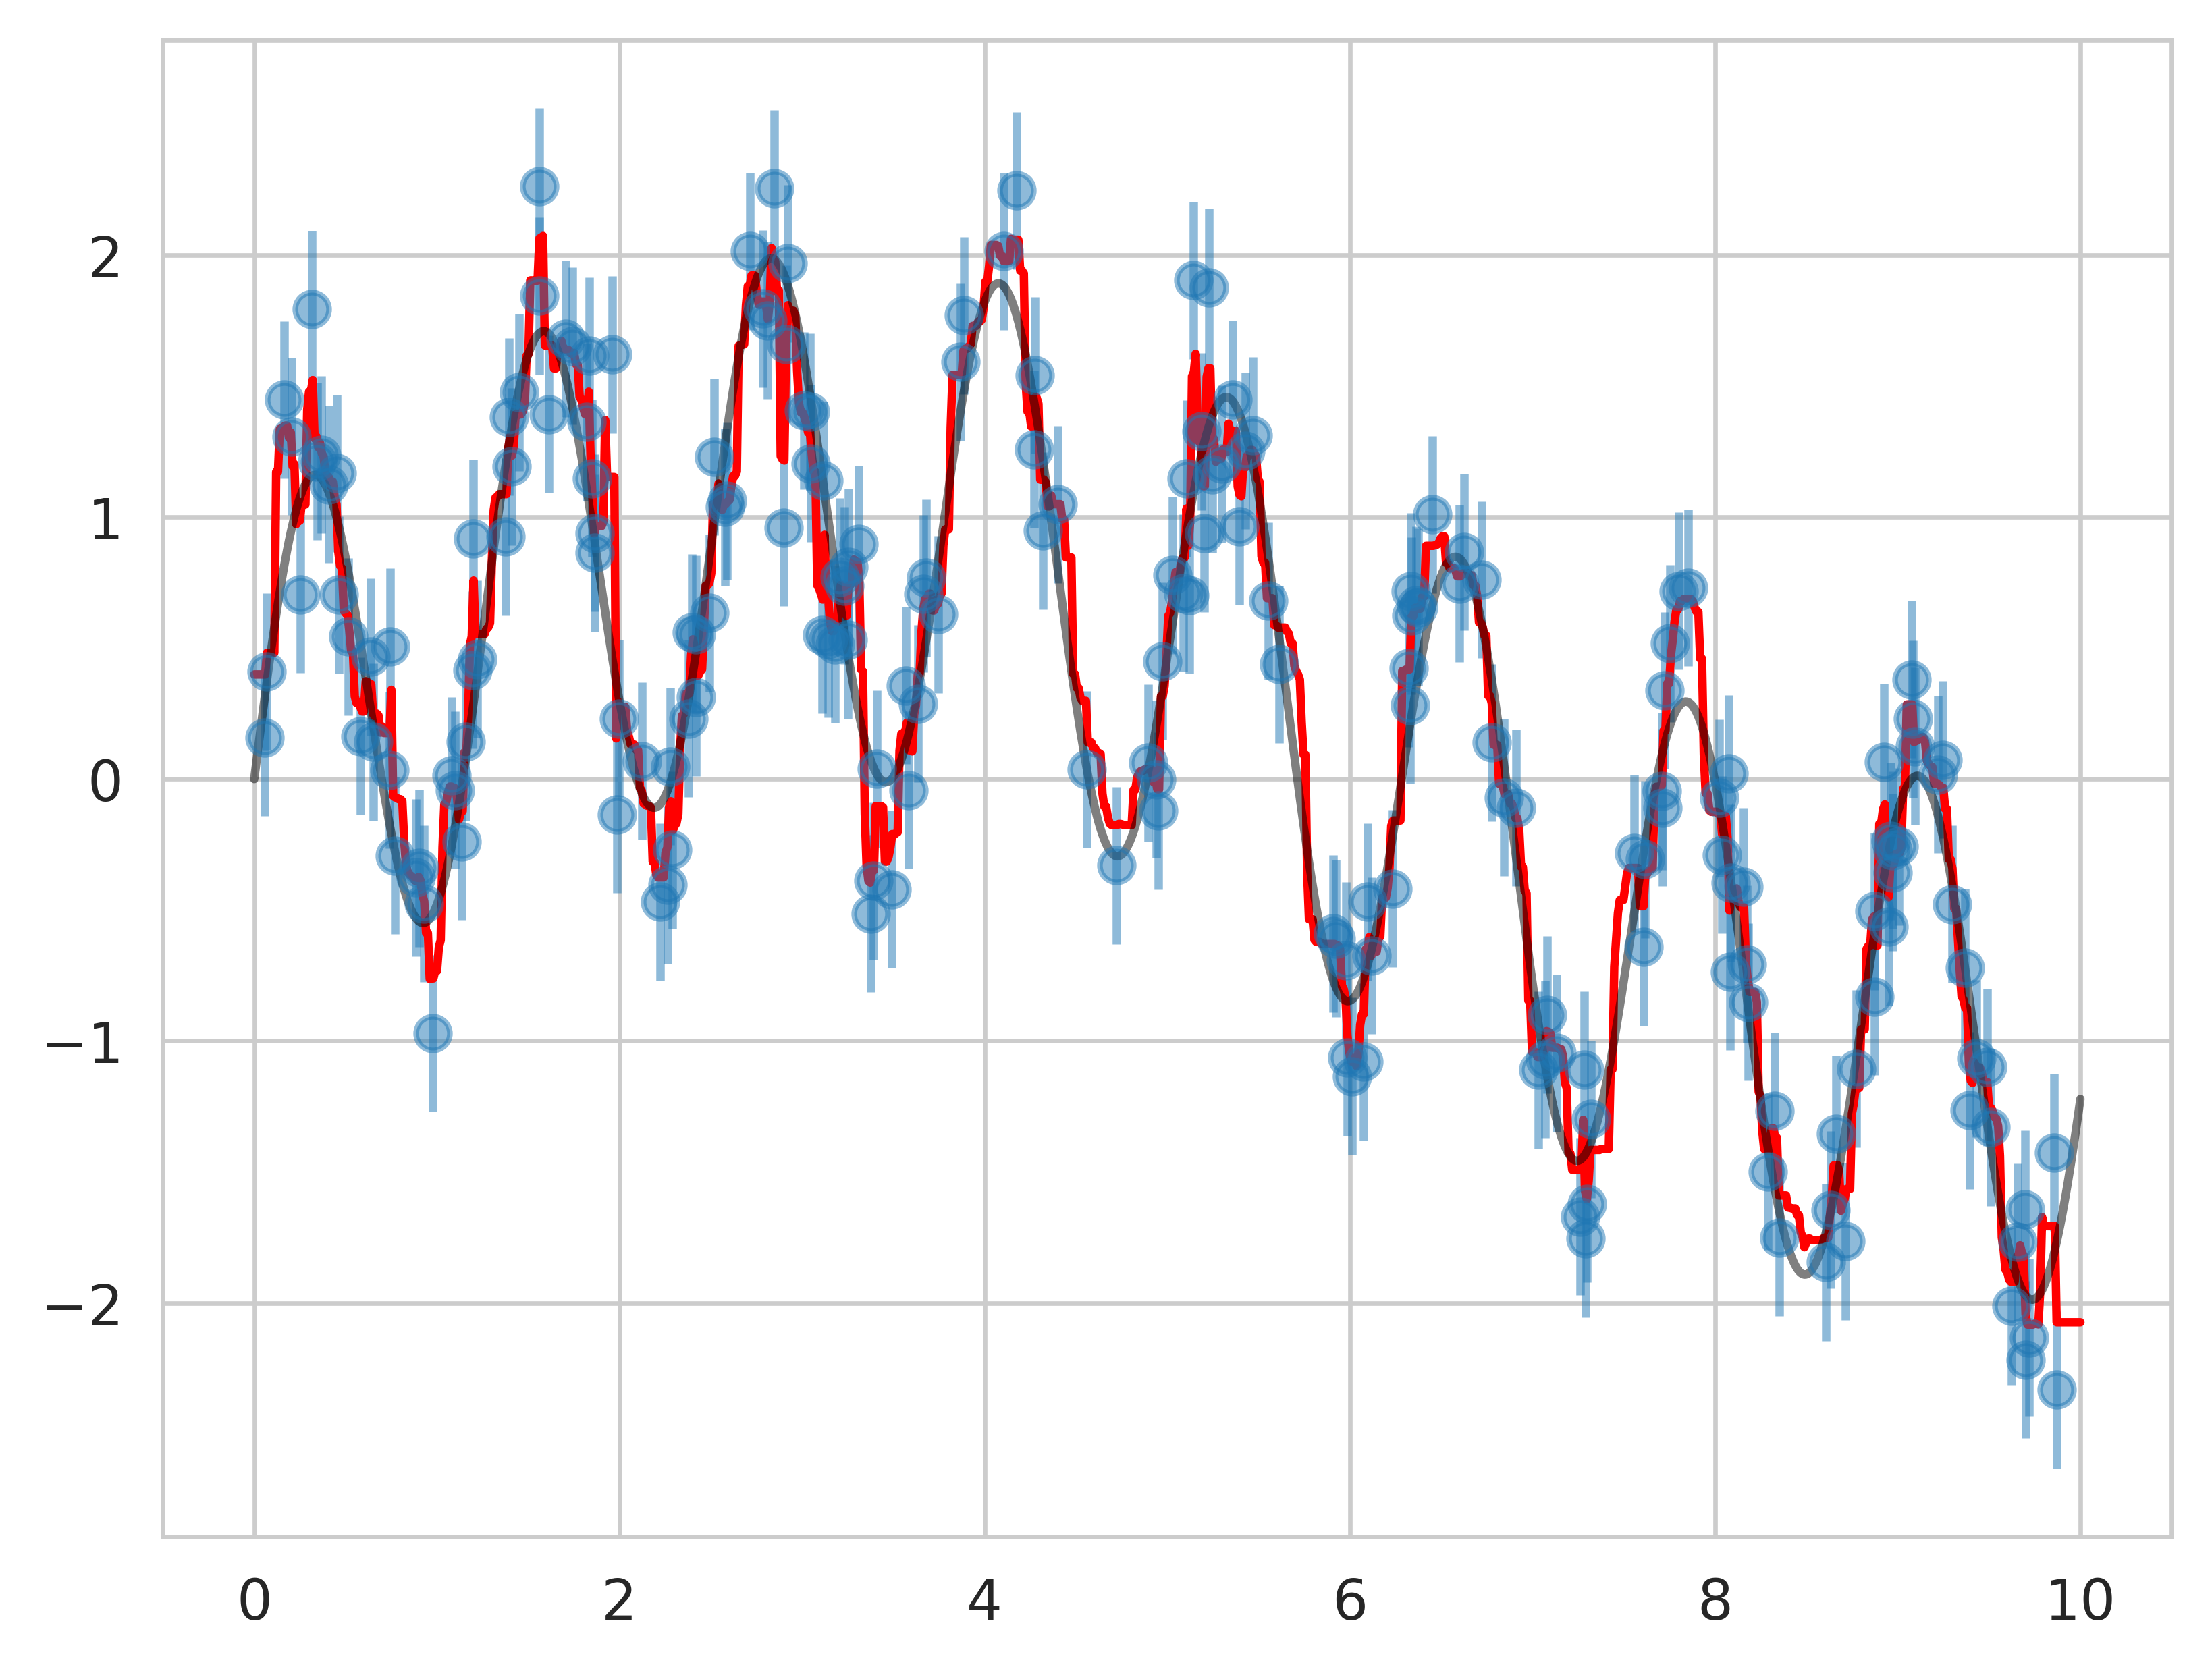

In [71]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Aquí, el modelo real se muestra en la curva gris suave, mientras que el modelo de bosque aleatorio se muestra en la curva roja irregular.
El modelo de bosque aleatorio no paramétrico es lo suficientemente flexible como para ajustarse a los datos multiperiodo, sin necesidad de especificar un modelo multiperiodo.

## Ejemplo: Bosque aleatorio para clasificar dígitos
En el capítulo 38, trabajamos con un ejemplo utilizando el conjunto de datos de dígitos incluido en Scikit-Learn.
Utilicémoslo de nuevo para ver cómo se puede aplicar el clasificador de bosque aleatorio en este contexto:

In [72]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

Para recordarnos lo que estamos viendo, visualizaremos los primeros puntos de datos (ver la siguiente figura):

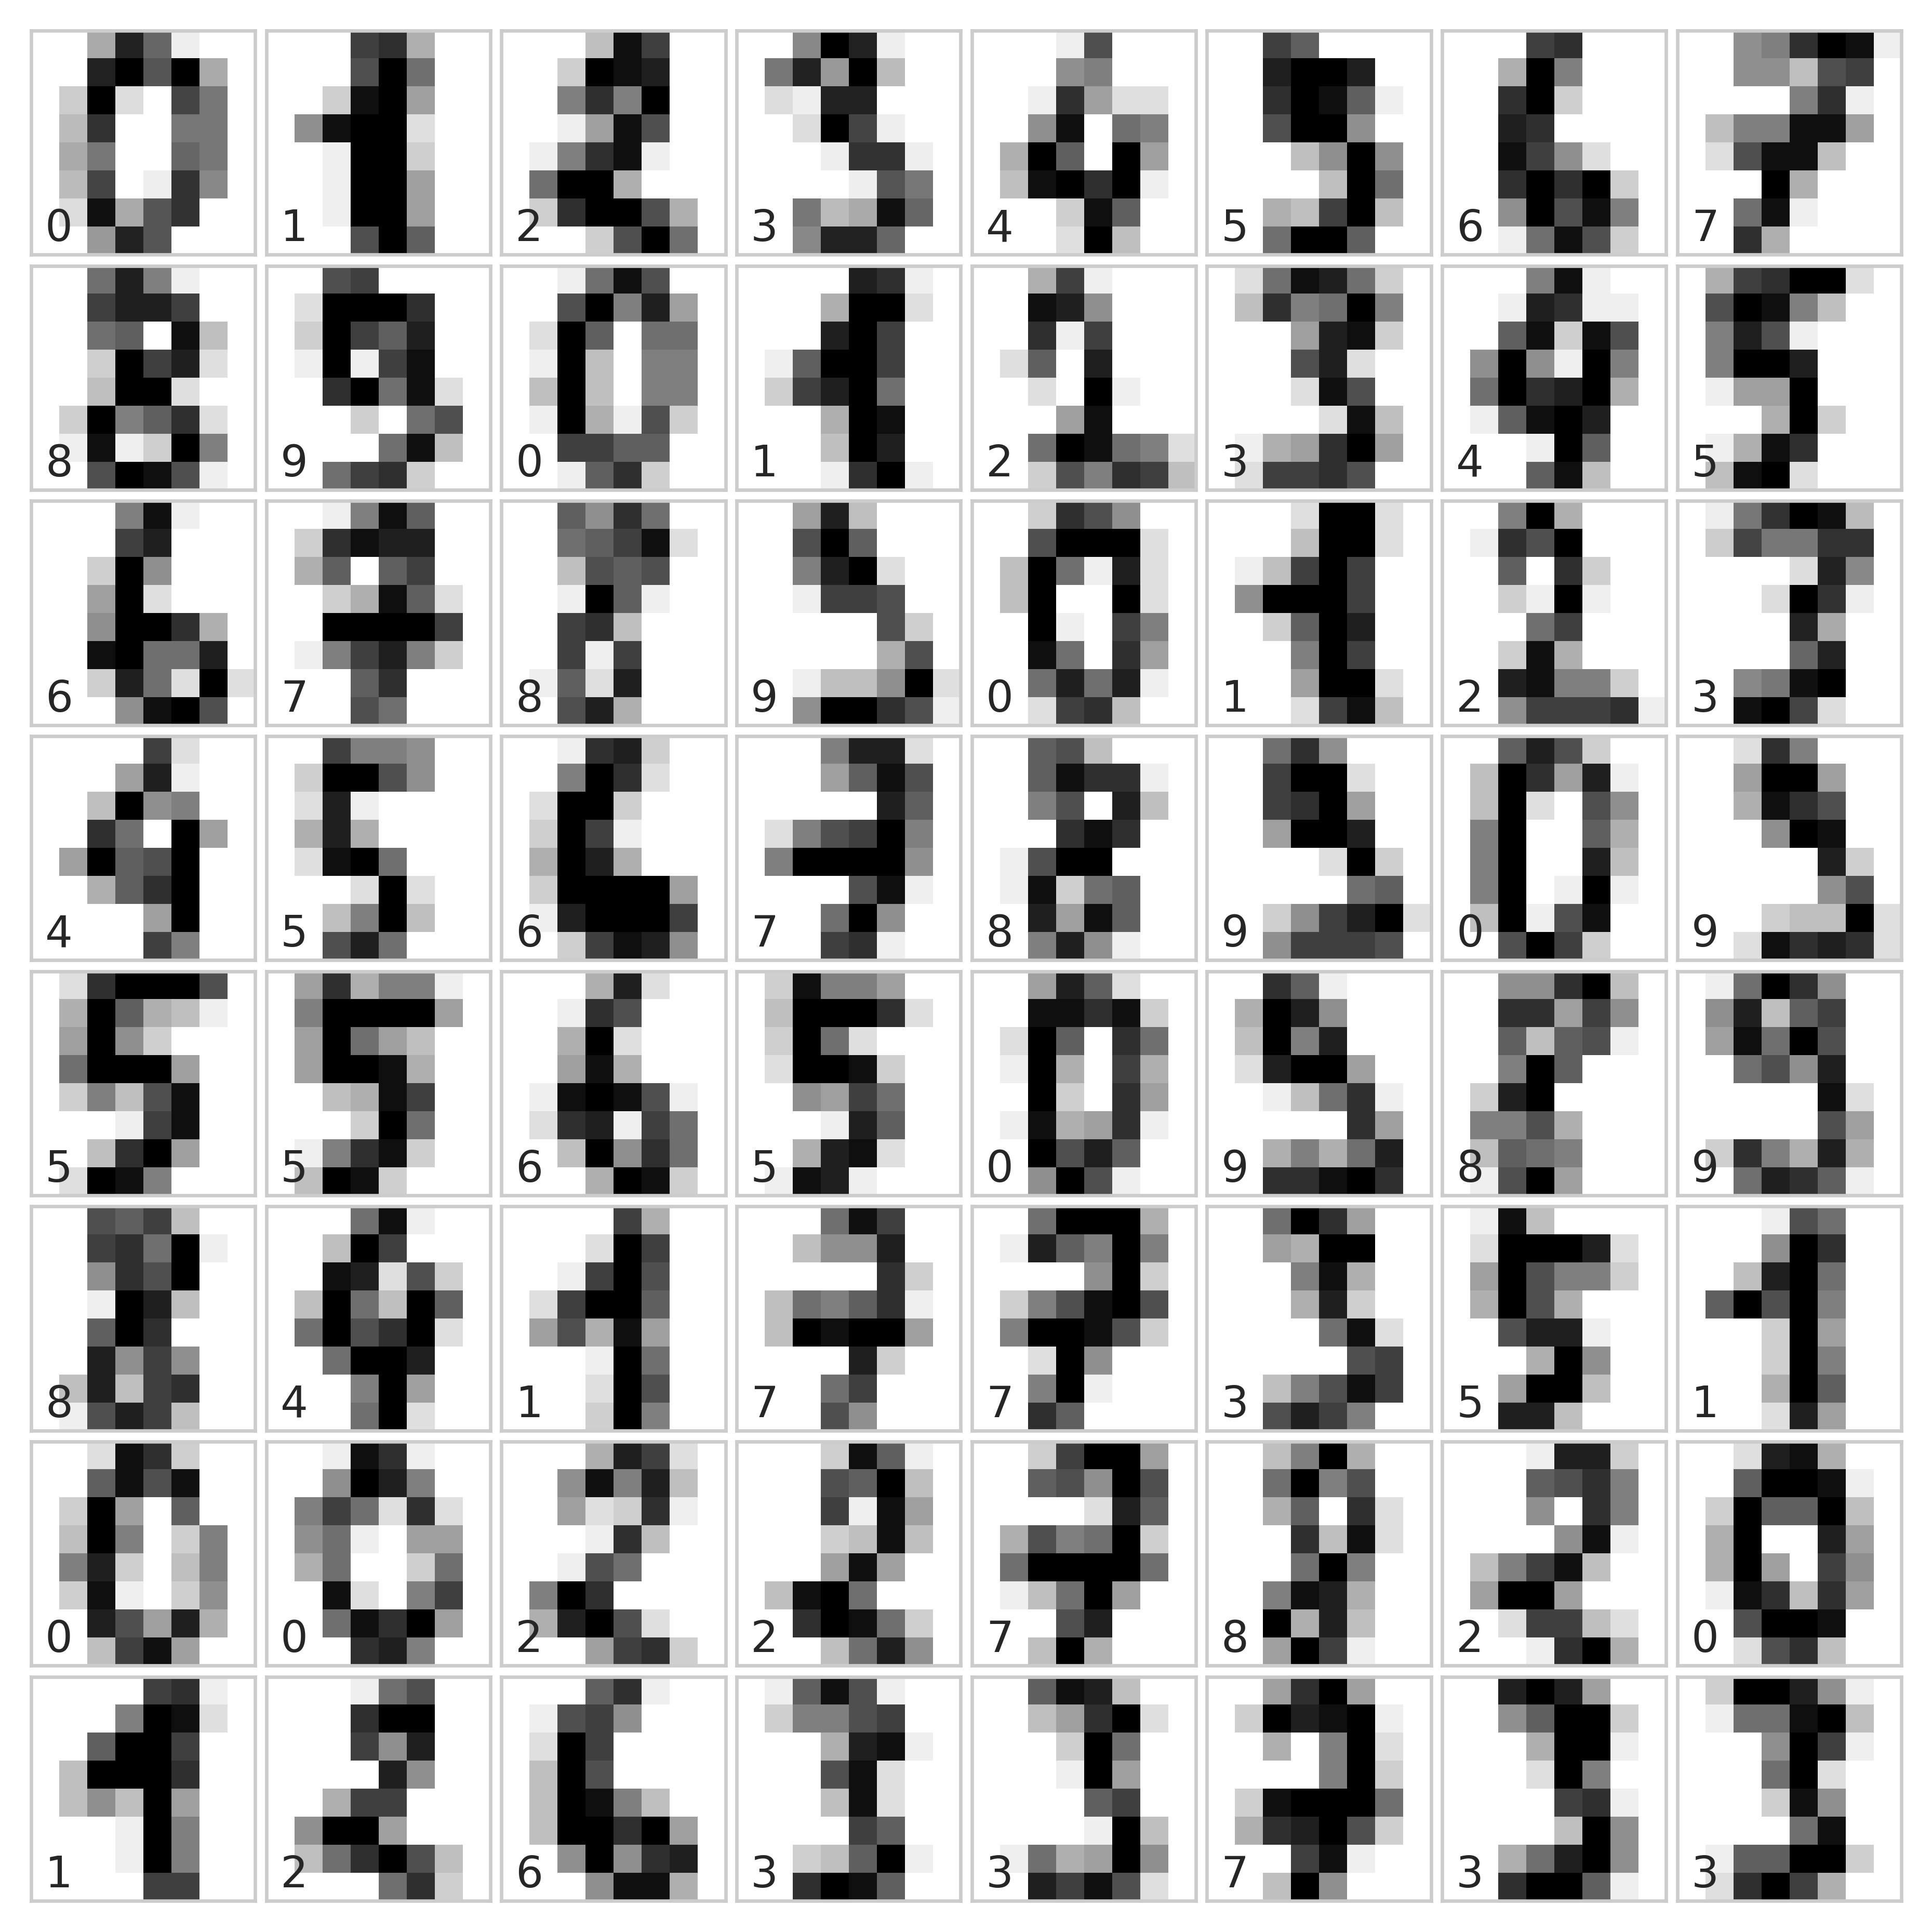

In [73]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

Podemos clasificar los dígitos utilizando un bosque aleatorio de la siguiente manera:

In [74]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

Veamos el informe de clasificación de este clasificador:

In [75]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       1.00      0.98      0.99        44
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.98      0.98        48
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



Y por si fuera poco, grafica la matriz de confusión (ver la siguiente figura):

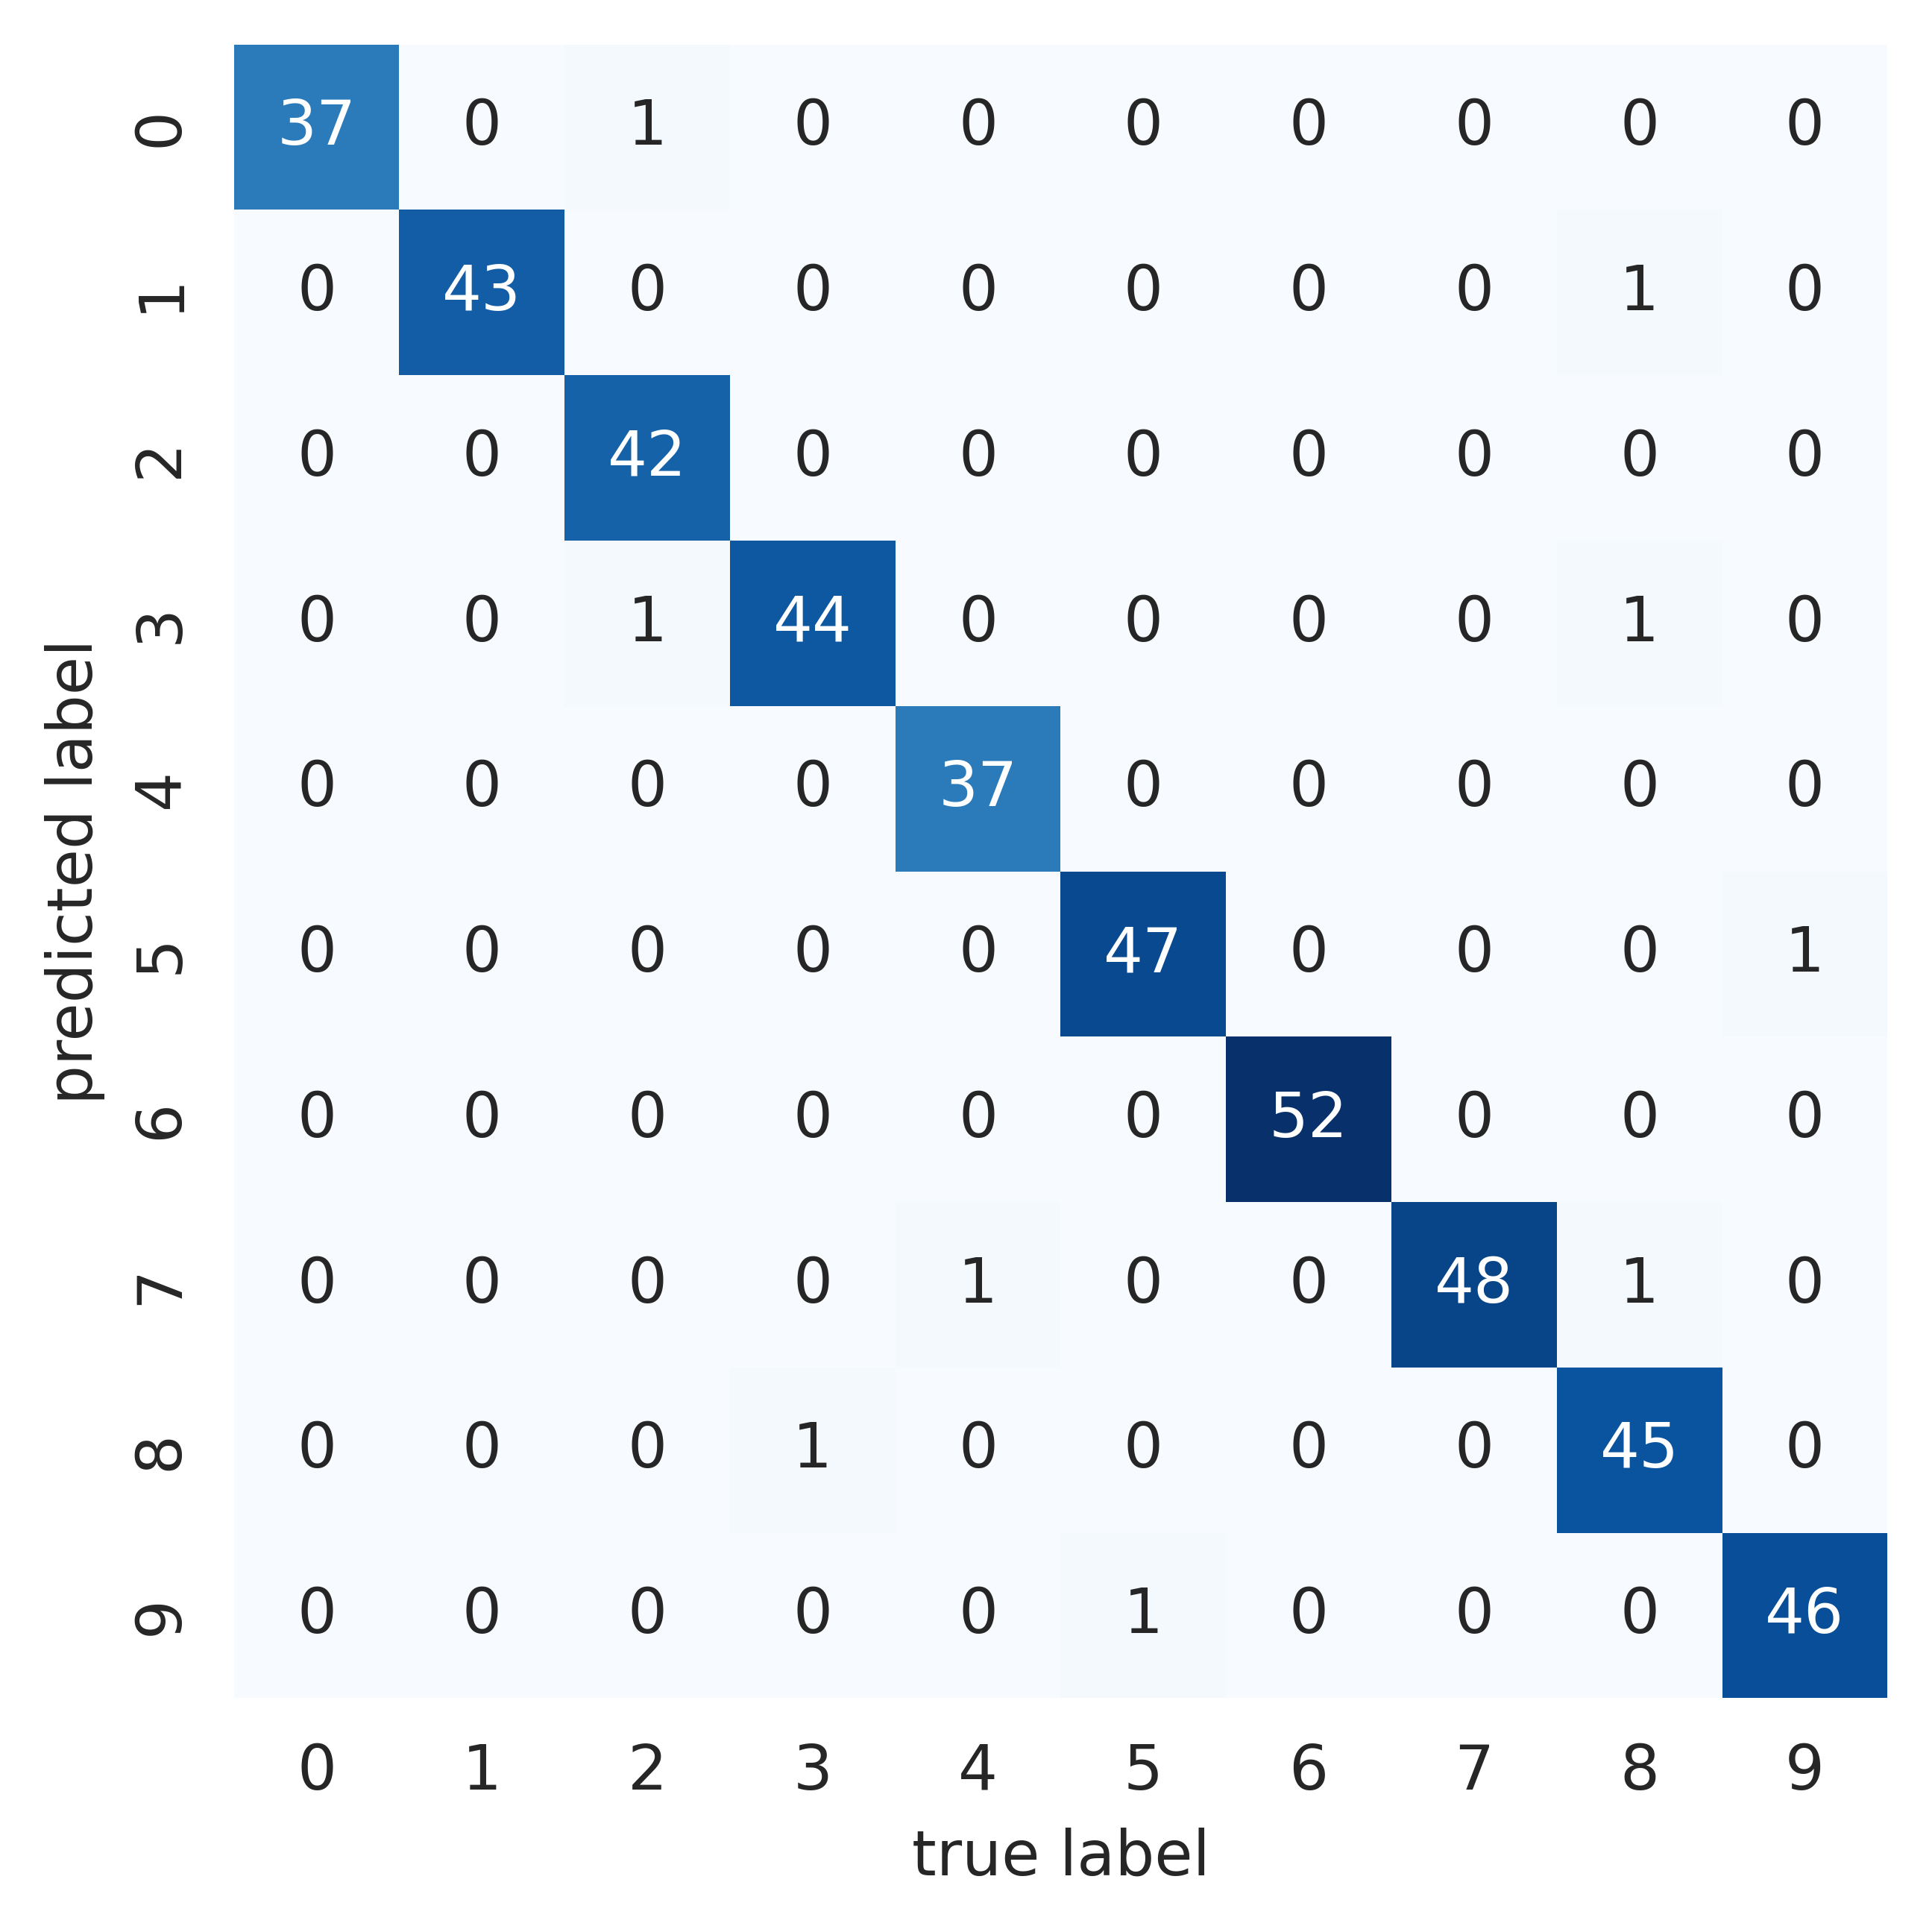

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label');

Descubrimos que un bosque aleatorio simple y no ajustado da como resultado una clasificación bastante precisa de los datos de dígitos.

## Resumen

Este capítulo ofreció una breve introducción al concepto de estimadores de conjunto, y en particular al bosque aleatorio, un conjunto de árboles de decisión aleatorios.
Los bosques aleatorios son un método potente con varias ventajas:

- Tanto el entrenamiento como la predicción son muy rápidos gracias a la simplicidad de los árboles de decisión subyacentes. Además, ambas tareas se pueden paralelizar fácilmente, ya que los árboles individuales son entidades completamente independientes.
- Los árboles múltiples permiten una clasificación probabilística: una votación mayoritaria entre los estimadores proporciona una estimación de la probabilidad (accesible en Scikit-Learn con el método `predict_proba`).
- El modelo no paramétrico es extremadamente flexible y, por lo tanto, puede funcionar bien en tareas que no se ajustan correctamente a otros estimadores.

Una desventaja principal de los bosques aleatorios es que los resultados no son fácilmente interpretables: es decir, si se desea extraer conclusiones sobre el *significado* del modelo de clasificación, los bosques aleatorios pueden no ser la mejor opción.